In [1]:
NN_TYPE = 'simple_lstm_only_speeds'

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from place_groups import selected_junctions, selected_middle_of_roads
from speed_data_maker import default_bootstrap_speed_data_maker
from common import *

import random
from sklearn.linear_model import LinearRegression
from datetime import timedelta
from keras.callbacks import ModelCheckpoint
import numpy as np
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras import regularizers

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 16

# prevent tensorflow from allocating the entire GPU memory at once
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

Using TensorFlow backend.


In [4]:
def build_model(lstm_state_size, num_lags, num_outs, loss):
    model = Sequential()
    model.add(LSTM(lstm_state_size, input_shape=(num_lags, 1), return_sequences=False))
    model.add(Dense(units=num_outs, activation="linear"))  # Linear activation, because speed RESIDUALS can have any sign.
    model.compile(loss=loss, optimizer="rmsprop")
    return model

In [5]:
def plot_model_training(history):
    plt.plot(history.history['loss'], linestyle='--')
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss in Train Phase')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [6]:
def create_and_train_model(loss, lstm_state_size, num_lags, num_outs,
                           place_id, speed_data_maker, mini_batch_size, num_epochs, validation_split):
    checkpoint_path = './hdf5/%d.hdf5' % random.randint(2**40, 2**41)
    print('Creating model %s' % checkpoint_path)
    x_train, y_train, _, _ = speed_data_maker.get_train_and_test_inputs()
    model = build_model(lstm_state_size=lstm_state_size, num_lags=num_lags, num_outs=num_outs, loss=loss)
    history = model.fit(
        np.expand_dims(np.array(x_train.values), 2),
        y_train.values,
        batch_size=mini_batch_size,
        epochs=num_epochs,
        validation_split=validation_split,
        callbacks=[ModelCheckpoint(
            checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')],
        verbose=2)
    model.load_weights(checkpoint_path)
    plot_model_training(history)
    return model, history, speed_data_maker

In [7]:
# model, history, speed_data_maker = create_and_train_model(
#     loss='mse', 
#     lstm_state_size=20, 
#     num_lags=NUM_LAGS, 
#     num_outs=1,
#     place_id=EXAMPLE_PLACE_ID, 
#     speed_data_maker=default_bootstrap_speed_data_maker(EXAMPLE_PLACE_ID),
#     mini_batch_size=512, 
#     num_epochs=100, 
#     validation_split=0.2)

In [8]:
def predict(model, speed_data_maker):
    _, _, x_test_normalized, y_test_normalized = speed_data_maker.get_train_and_test_inputs()
    predictions_normalized = model.predict(np.expand_dims(x_test_normalized, 2)).flatten()
    errors_df = speed_data_maker.individual_errors_without_interpolated_values(predictions_normalized)
    return compute_error_statistics(errors_df, 'speed_km_hr_true', 'speed_km_hr_predicted')

In [9]:
def one_place(place_id):
    model, history, speed_data_maker = create_and_train_model(
        loss='mse', 
        lstm_state_size=20, 
        num_lags=NUM_LAGS, 
        num_outs=1,
        place_id=place_id, 
        speed_data_maker=default_bootstrap_speed_data_maker(place_id),
        mini_batch_size=512, 
        num_epochs=100, 
        validation_split=0.2)
    return pd.DataFrame({NN_TYPE: predict(model, speed_data_maker)})\
        .reset_index()\
        .rename(columns={'index': 'stat'})\
        .assign(place_id=place_id)\
        .set_index(['place_id', 'stat'])

def all_places(group, name):
    pd.concat(map(one_place, group)).to_csv(name + '.csv')
    results = pd.read_csv('%s.csv' % name).groupby('stat').mean()
    results.to_csv('%s_summary.csv' % name)
    return results

Creating model ./hdf5/1176227343258.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.64621, saving model to ./hdf5/1176227343258.hdf5
 - 3s - loss: 0.8497 - val_loss: 0.6462
Epoch 2/100
Epoch 00002: val_loss improved from 0.64621 to 0.54093, saving model to ./hdf5/1176227343258.hdf5
 - 2s - loss: 0.6749 - val_loss: 0.5409
Epoch 3/100
Epoch 00003: val_loss improved from 0.54093 to 0.48944, saving model to ./hdf5/1176227343258.hdf5
 - 2s - loss: 0.5841 - val_loss: 0.4894
Epoch 4/100
Epoch 00004: val_loss improved from 0.48944 to 0.45111, saving model to ./hdf5/1176227343258.hdf5
 - 2s - loss: 0.5352 - val_loss: 0.4511
Epoch 5/100
Epoch 00005: val_loss improved from 0.45111 to 0.44271, saving model to ./hdf5/1176227343258.hdf5
 - 2s - loss: 0.5086 - val_loss: 0.4427
Epoch 6/100
Epoch 00006: val_loss improved from 0.44271 to 0.41801, saving model to ./hdf5/1176227343258.hdf5
 - 2s - loss: 0.4877 - val_loss: 0.4180
Epoch 7/100
Ep

Epoch 74/100
Epoch 00074: val_loss did not improve
 - 2s - loss: 0.2756 - val_loss: 0.2399
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 2s - loss: 0.2725 - val_loss: 0.2966
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2729 - val_loss: 0.2451
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 2s - loss: 0.2708 - val_loss: 0.2544
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 2s - loss: 0.2722 - val_loss: 0.2794
Epoch 79/100
Epoch 00079: val_loss improved from 0.23425 to 0.22501, saving model to ./hdf5/1176227343258.hdf5
 - 2s - loss: 0.2715 - val_loss: 0.2250
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 2s - loss: 0.2714 - val_loss: 0.2646
Epoch 81/100
Epoch 00081: val_loss did not improve
 - 2s - loss: 0.2699 - val_loss: 0.2380
Epoch 82/100
Epoch 00082: val_loss did not improve
 - 2s - loss: 0.2681 - val_loss: 0.2393
Epoch 83/100
Epoch 00083: val_loss did not improve
 - 2s - loss: 0.2684 - val_loss: 0.2517
Epoch 84/100
Epoch 00084: val_

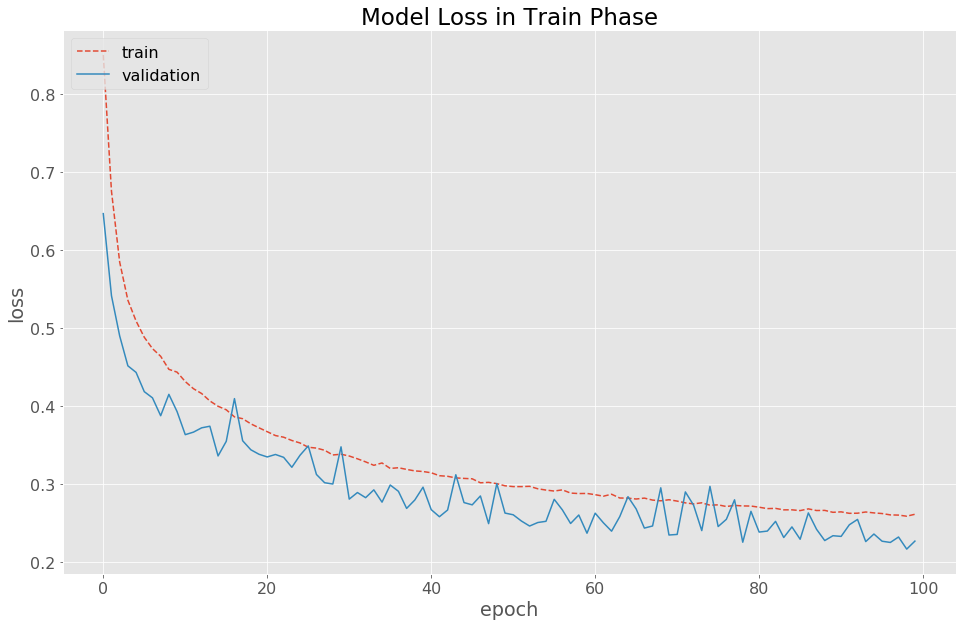

Creating model ./hdf5/1116606652674.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.64519, saving model to ./hdf5/1116606652674.hdf5
 - 2s - loss: 0.8558 - val_loss: 0.6452
Epoch 2/100
Epoch 00002: val_loss improved from 0.64519 to 0.52572, saving model to ./hdf5/1116606652674.hdf5
 - 2s - loss: 0.6833 - val_loss: 0.5257
Epoch 3/100
Epoch 00003: val_loss improved from 0.52572 to 0.43332, saving model to ./hdf5/1116606652674.hdf5
 - 2s - loss: 0.5588 - val_loss: 0.4333
Epoch 4/100
Epoch 00004: val_loss improved from 0.43332 to 0.43251, saving model to ./hdf5/1116606652674.hdf5
 - 2s - loss: 0.4990 - val_loss: 0.4325
Epoch 5/100
Epoch 00005: val_loss improved from 0.43251 to 0.38290, saving model to ./hdf5/1116606652674.hdf5
 - 2s - loss: 0.4798 - val_loss: 0.3829
Epoch 6/100
Epoch 00006: val_loss improved from 0.38290 to 0.37227, saving model to ./hdf5/1116606652674.hdf5
 - 2s - loss: 0.4595 - val_loss: 0.3723
Epoch 7/100
Ep

Epoch 75/100
Epoch 00075: val_loss did not improve
 - 2s - loss: 0.2358 - val_loss: 0.2216
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2328 - val_loss: 0.2017
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 2s - loss: 0.2329 - val_loss: 0.2167
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 2s - loss: 0.2313 - val_loss: 0.2282
Epoch 79/100
Epoch 00079: val_loss improved from 0.19329 to 0.18965, saving model to ./hdf5/1116606652674.hdf5
 - 2s - loss: 0.2304 - val_loss: 0.1896
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 2s - loss: 0.2300 - val_loss: 0.1977
Epoch 81/100
Epoch 00081: val_loss improved from 0.18965 to 0.18881, saving model to ./hdf5/1116606652674.hdf5
 - 2s - loss: 0.2296 - val_loss: 0.1888
Epoch 82/100
Epoch 00082: val_loss did not improve
 - 2s - loss: 0.2287 - val_loss: 0.2124
Epoch 83/100
Epoch 00083: val_loss did not improve
 - 2s - loss: 0.2284 - val_loss: 0.1965
Epoch 84/100
Epoch 00084: val_loss did not improve
 - 2s - lo

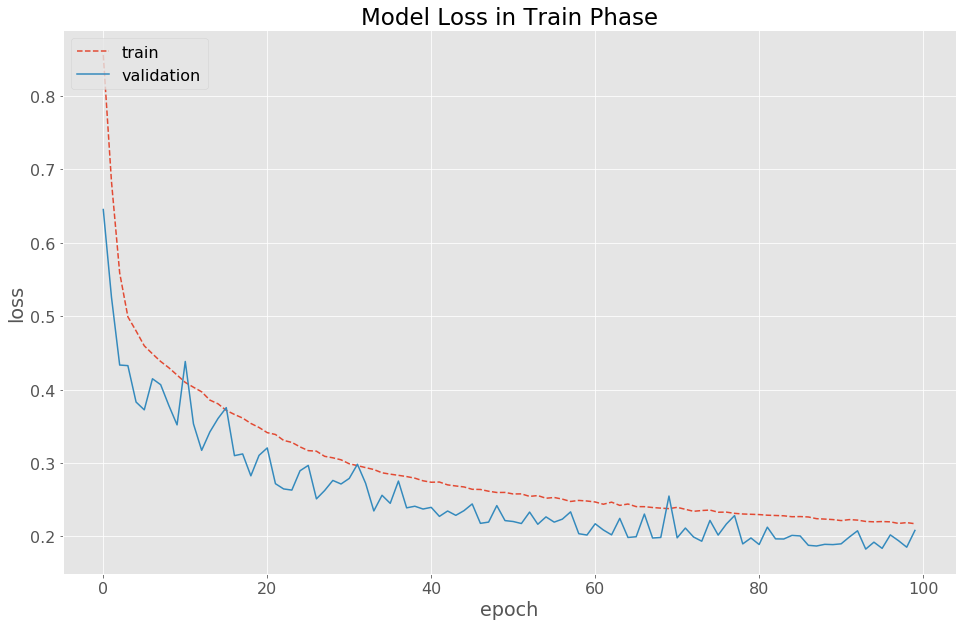

Creating model ./hdf5/1466380438459.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.70819, saving model to ./hdf5/1466380438459.hdf5
 - 2s - loss: 0.8756 - val_loss: 0.7082
Epoch 2/100
Epoch 00002: val_loss improved from 0.70819 to 0.58182, saving model to ./hdf5/1466380438459.hdf5
 - 2s - loss: 0.6803 - val_loss: 0.5818
Epoch 3/100
Epoch 00003: val_loss improved from 0.58182 to 0.46245, saving model to ./hdf5/1466380438459.hdf5
 - 2s - loss: 0.5589 - val_loss: 0.4625
Epoch 4/100
Epoch 00004: val_loss improved from 0.46245 to 0.40055, saving model to ./hdf5/1466380438459.hdf5
 - 2s - loss: 0.4918 - val_loss: 0.4005
Epoch 5/100
Epoch 00005: val_loss did not improve
 - 2s - loss: 0.4624 - val_loss: 0.4029
Epoch 6/100
Epoch 00006: val_loss improved from 0.40055 to 0.38229, saving model to ./hdf5/1466380438459.hdf5
 - 2s - loss: 0.4478 - val_loss: 0.3823
Epoch 7/100
Epoch 00007: val_loss did not improve
 - 2s - loss: 0.4343 - v

Epoch 73/100
Epoch 00073: val_loss did not improve
 - 1s - loss: 0.2278 - val_loss: 0.2128
Epoch 74/100
Epoch 00074: val_loss improved from 0.19927 to 0.19448, saving model to ./hdf5/1466380438459.hdf5
 - 1s - loss: 0.2254 - val_loss: 0.1945
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 1s - loss: 0.2280 - val_loss: 0.1999
Epoch 76/100
Epoch 00076: val_loss improved from 0.19448 to 0.18687, saving model to ./hdf5/1466380438459.hdf5
 - 1s - loss: 0.2238 - val_loss: 0.1869
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 1s - loss: 0.2234 - val_loss: 0.2075
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 1s - loss: 0.2221 - val_loss: 0.2088
Epoch 79/100
Epoch 00079: val_loss did not improve
 - 1s - loss: 0.2227 - val_loss: 0.1921
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 1s - loss: 0.2207 - val_loss: 0.2166
Epoch 81/100
Epoch 00081: val_loss did not improve
 - 2s - loss: 0.2194 - val_loss: 0.2112
Epoch 82/100
Epoch 00082: val_loss improved from 0.18687 to 0

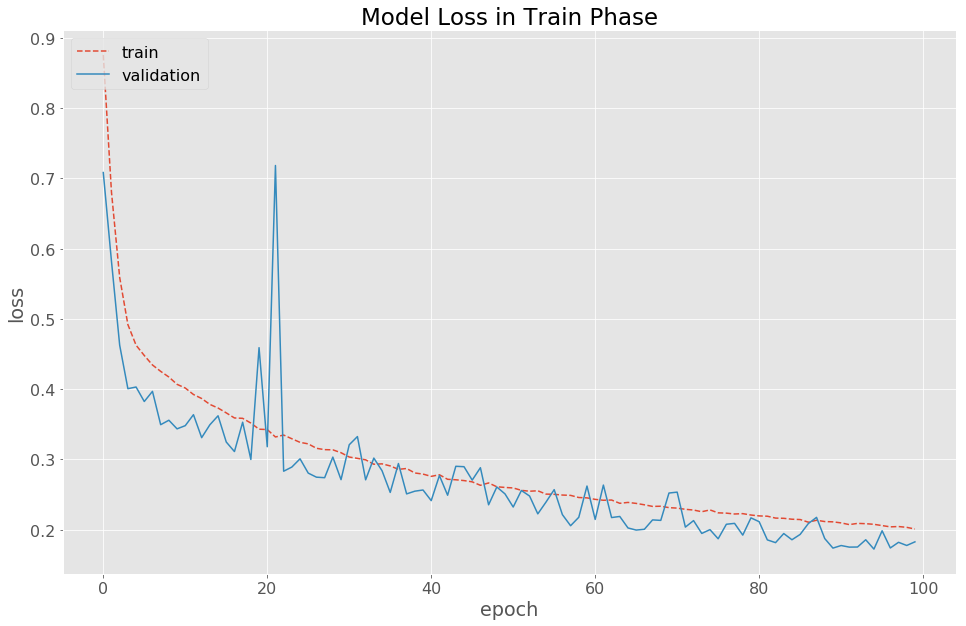

Creating model ./hdf5/1278864820107.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.76135, saving model to ./hdf5/1278864820107.hdf5
 - 2s - loss: 0.9377 - val_loss: 0.7614
Epoch 2/100
Epoch 00002: val_loss improved from 0.76135 to 0.61275, saving model to ./hdf5/1278864820107.hdf5
 - 1s - loss: 0.7541 - val_loss: 0.6127
Epoch 3/100
Epoch 00003: val_loss improved from 0.61275 to 0.54490, saving model to ./hdf5/1278864820107.hdf5
 - 2s - loss: 0.6374 - val_loss: 0.5449
Epoch 4/100
Epoch 00004: val_loss did not improve
 - 2s - loss: 0.5811 - val_loss: 0.5803
Epoch 5/100
Epoch 00005: val_loss improved from 0.54490 to 0.45703, saving model to ./hdf5/1278864820107.hdf5
 - 2s - loss: 0.5535 - val_loss: 0.4570
Epoch 6/100
Epoch 00006: val_loss did not improve
 - 1s - loss: 0.5318 - val_loss: 0.5205
Epoch 7/100
Epoch 00007: val_loss did not improve
 - 1s - loss: 0.5127 - val_loss: 0.4602
Epoch 8/100
Epoch 00008: val_loss did not im

Epoch 00073: val_loss did not improve
 - 1s - loss: 0.3651 - val_loss: 0.3595
Epoch 74/100
Epoch 00074: val_loss did not improve
 - 1s - loss: 0.3639 - val_loss: 0.3205
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 1s - loss: 0.3628 - val_loss: 0.3145
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 1s - loss: 0.3630 - val_loss: 0.3255
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 1s - loss: 0.3635 - val_loss: 0.3183
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 1s - loss: 0.3617 - val_loss: 0.3743
Epoch 79/100
Epoch 00079: val_loss improved from 0.31307 to 0.30983, saving model to ./hdf5/1278864820107.hdf5
 - 2s - loss: 0.3608 - val_loss: 0.3098
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 1s - loss: 0.3620 - val_loss: 0.3161
Epoch 81/100
Epoch 00081: val_loss did not improve
 - 1s - loss: 0.3618 - val_loss: 0.3208
Epoch 82/100
Epoch 00082: val_loss did not improve
 - 1s - loss: 0.3593 - val_loss: 0.3315
Epoch 83/100
Epoch 00083: val_loss did not 

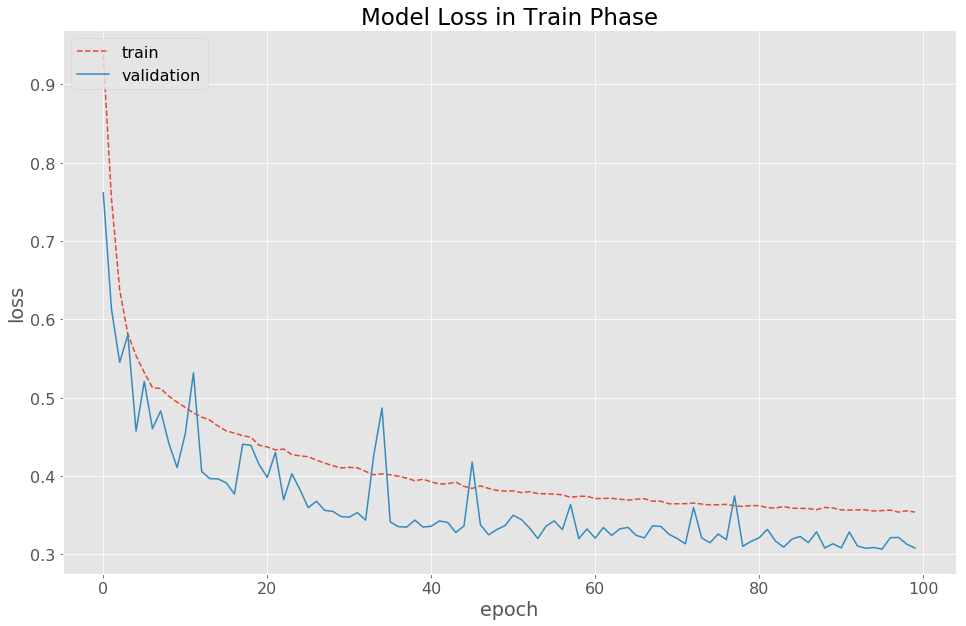

Creating model ./hdf5/2022631567316.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.68366, saving model to ./hdf5/2022631567316.hdf5
 - 2s - loss: 0.8965 - val_loss: 0.6837
Epoch 2/100
Epoch 00002: val_loss improved from 0.68366 to 0.56348, saving model to ./hdf5/2022631567316.hdf5
 - 2s - loss: 0.7333 - val_loss: 0.5635
Epoch 3/100
Epoch 00003: val_loss improved from 0.56348 to 0.48096, saving model to ./hdf5/2022631567316.hdf5
 - 2s - loss: 0.6087 - val_loss: 0.4810
Epoch 4/100
Epoch 00004: val_loss improved from 0.48096 to 0.42501, saving model to ./hdf5/2022631567316.hdf5
 - 2s - loss: 0.5401 - val_loss: 0.4250
Epoch 5/100
Epoch 00005: val_loss did not improve
 - 2s - loss: 0.5073 - val_loss: 0.4271
Epoch 6/100
Epoch 00006: val_loss did not improve
 - 1s - loss: 0.4863 - val_loss: 0.4455
Epoch 7/100
Epoch 00007: val_loss improved from 0.42501 to 0.36912, saving model to ./hdf5/2022631567316.hdf5
 - 2s - loss: 0.4762 - v

Epoch 72/100
Epoch 00072: val_loss did not improve
 - 1s - loss: 0.2791 - val_loss: 0.2123
Epoch 73/100
Epoch 00073: val_loss did not improve
 - 1s - loss: 0.2790 - val_loss: 0.2091
Epoch 74/100
Epoch 00074: val_loss did not improve
 - 1s - loss: 0.2748 - val_loss: 0.2306
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 1s - loss: 0.2748 - val_loss: 0.2181
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2738 - val_loss: 0.2187
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 2s - loss: 0.2733 - val_loss: 0.2514
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 1s - loss: 0.2749 - val_loss: 0.2257
Epoch 79/100
Epoch 00079: val_loss did not improve
 - 1s - loss: 0.2720 - val_loss: 0.2257
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 1s - loss: 0.2698 - val_loss: 0.2234
Epoch 81/100
Epoch 00081: val_loss improved from 0.20796 to 0.20708, saving model to ./hdf5/2022631567316.hdf5
 - 1s - loss: 0.2703 - val_loss: 0.2071
Epoch 82/100
Epoch 00082: val_

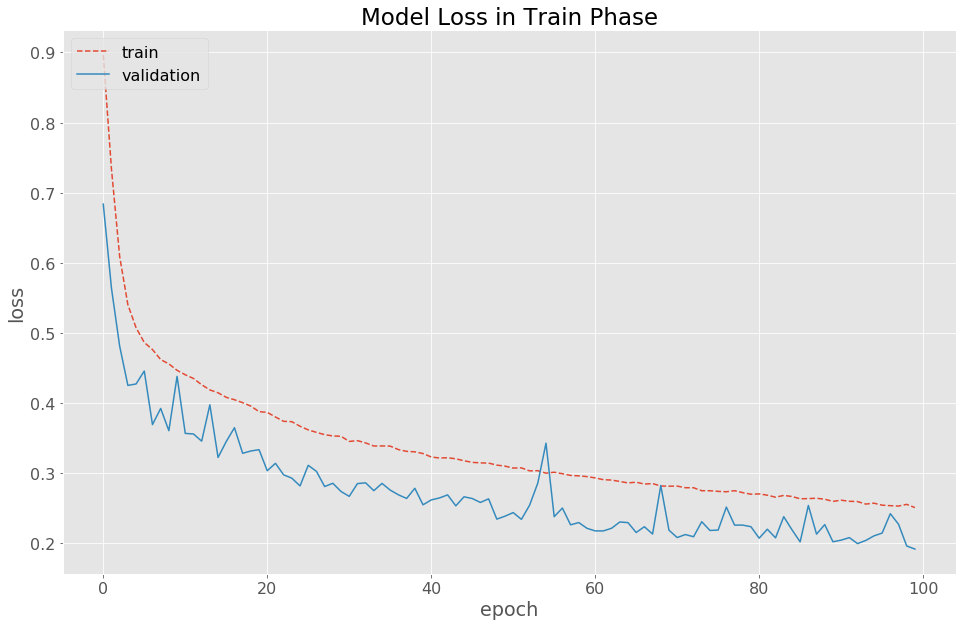

Creating model ./hdf5/2000307033683.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.75280, saving model to ./hdf5/2000307033683.hdf5
 - 2s - loss: 0.8550 - val_loss: 0.7528
Epoch 2/100
Epoch 00002: val_loss improved from 0.75280 to 0.64686, saving model to ./hdf5/2000307033683.hdf5
 - 2s - loss: 0.6862 - val_loss: 0.6469
Epoch 3/100
Epoch 00003: val_loss improved from 0.64686 to 0.55200, saving model to ./hdf5/2000307033683.hdf5
 - 2s - loss: 0.5906 - val_loss: 0.5520
Epoch 4/100
Epoch 00004: val_loss improved from 0.55200 to 0.49507, saving model to ./hdf5/2000307033683.hdf5
 - 1s - loss: 0.5355 - val_loss: 0.4951
Epoch 5/100
Epoch 00005: val_loss improved from 0.49507 to 0.46358, saving model to ./hdf5/2000307033683.hdf5
 - 1s - loss: 0.4992 - val_loss: 0.4636
Epoch 6/100
Epoch 00006: val_loss improved from 0.46358 to 0.43860, saving model to ./hdf5/2000307033683.hdf5
 - 1s - loss: 0.4765 - val_loss: 0.4386
Epoch 7/100
Ep

Epoch 71/100
Epoch 00071: val_loss did not improve
 - 1s - loss: 0.2705 - val_loss: 0.2565
Epoch 72/100
Epoch 00072: val_loss did not improve
 - 1s - loss: 0.2681 - val_loss: 0.2518
Epoch 73/100
Epoch 00073: val_loss improved from 0.24652 to 0.24443, saving model to ./hdf5/2000307033683.hdf5
 - 1s - loss: 0.2675 - val_loss: 0.2444
Epoch 74/100
Epoch 00074: val_loss did not improve
 - 2s - loss: 0.2658 - val_loss: 0.2505
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 2s - loss: 0.2669 - val_loss: 0.2536
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2643 - val_loss: 0.2524
Epoch 77/100
Epoch 00077: val_loss improved from 0.24443 to 0.24032, saving model to ./hdf5/2000307033683.hdf5
 - 2s - loss: 0.2643 - val_loss: 0.2403
Epoch 78/100
Epoch 00078: val_loss improved from 0.24032 to 0.23729, saving model to ./hdf5/2000307033683.hdf5
 - 2s - loss: 0.2643 - val_loss: 0.2373
Epoch 79/100
Epoch 00079: val_loss improved from 0.23729 to 0.23527, saving model to ./hdf5/

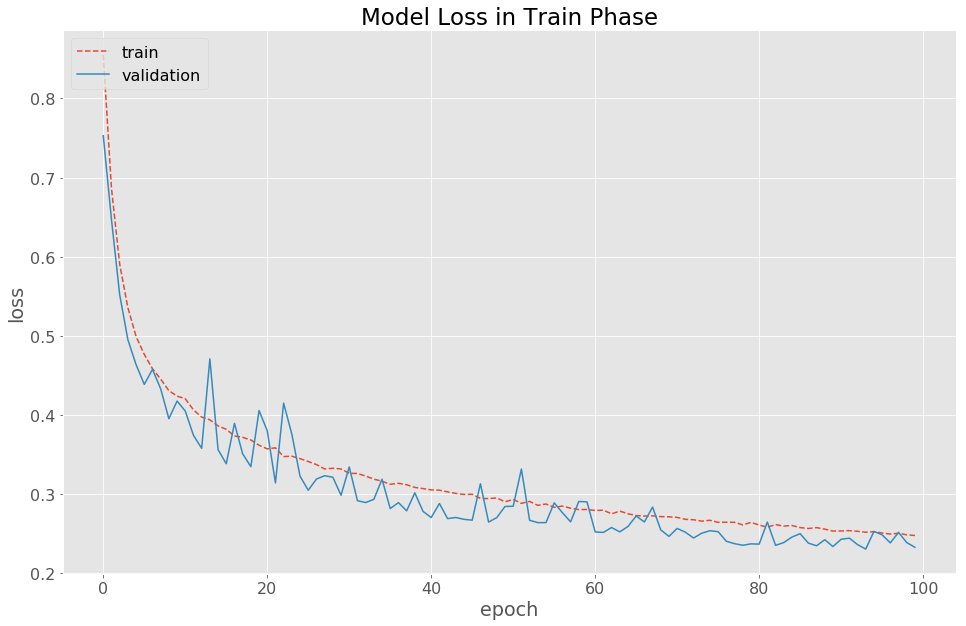

Creating model ./hdf5/2070680605432.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.71467, saving model to ./hdf5/2070680605432.hdf5
 - 2s - loss: 0.8829 - val_loss: 0.7147
Epoch 2/100
Epoch 00002: val_loss improved from 0.71467 to 0.57203, saving model to ./hdf5/2070680605432.hdf5
 - 2s - loss: 0.6904 - val_loss: 0.5720
Epoch 3/100
Epoch 00003: val_loss improved from 0.57203 to 0.48705, saving model to ./hdf5/2070680605432.hdf5
 - 1s - loss: 0.5595 - val_loss: 0.4870
Epoch 4/100
Epoch 00004: val_loss improved from 0.48705 to 0.48532, saving model to ./hdf5/2070680605432.hdf5
 - 2s - loss: 0.5129 - val_loss: 0.4853
Epoch 5/100
Epoch 00005: val_loss improved from 0.48532 to 0.42274, saving model to ./hdf5/2070680605432.hdf5
 - 2s - loss: 0.4917 - val_loss: 0.4227
Epoch 6/100
Epoch 00006: val_loss did not improve
 - 2s - loss: 0.4791 - val_loss: 0.4343
Epoch 7/100
Epoch 00007: val_loss improved from 0.42274 to 0.42223, saving

Epoch 74/100
Epoch 00074: val_loss did not improve
 - 2s - loss: 0.2627 - val_loss: 0.2383
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 2s - loss: 0.2612 - val_loss: 0.2794
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2600 - val_loss: 0.2532
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 1s - loss: 0.2568 - val_loss: 0.3143
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 2s - loss: 0.2589 - val_loss: 0.2553
Epoch 79/100
Epoch 00079: val_loss did not improve
 - 2s - loss: 0.2559 - val_loss: 0.2446
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 2s - loss: 0.2536 - val_loss: 0.2782
Epoch 81/100
Epoch 00081: val_loss did not improve
 - 2s - loss: 0.2535 - val_loss: 0.2381
Epoch 82/100
Epoch 00082: val_loss did not improve
 - 2s - loss: 0.2539 - val_loss: 0.2630
Epoch 83/100
Epoch 00083: val_loss did not improve
 - 2s - loss: 0.2527 - val_loss: 0.2541
Epoch 84/100
Epoch 00084: val_loss did not improve
 - 2s - loss: 0.2492 - val_loss: 0.2425

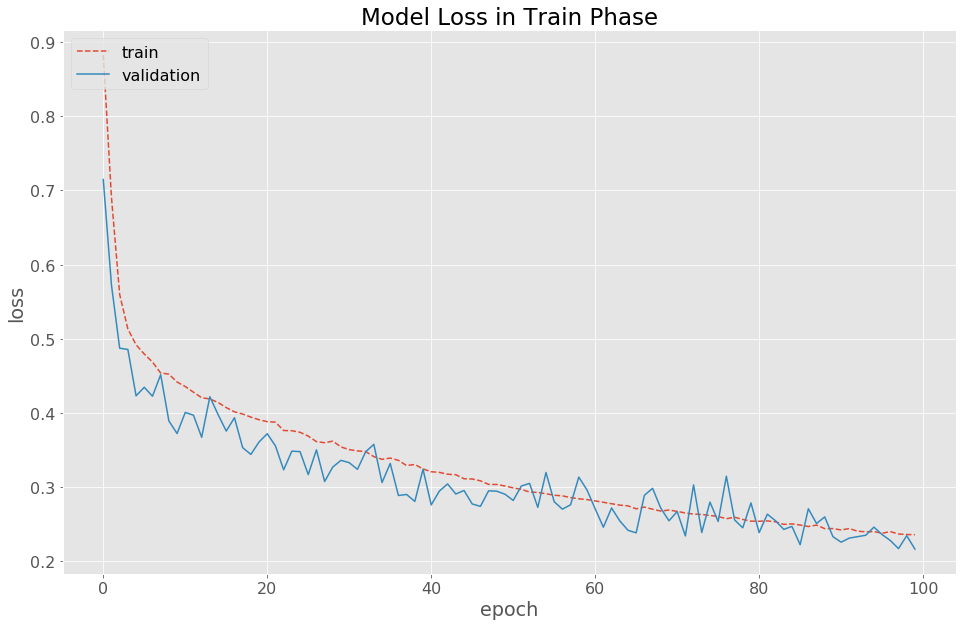

Creating model ./hdf5/1855504421996.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.64421, saving model to ./hdf5/1855504421996.hdf5
 - 2s - loss: 0.8708 - val_loss: 0.6442
Epoch 2/100
Epoch 00002: val_loss improved from 0.64421 to 0.48932, saving model to ./hdf5/1855504421996.hdf5
 - 2s - loss: 0.6730 - val_loss: 0.4893
Epoch 3/100
Epoch 00003: val_loss improved from 0.48932 to 0.44936, saving model to ./hdf5/1855504421996.hdf5
 - 2s - loss: 0.5472 - val_loss: 0.4494
Epoch 4/100
Epoch 00004: val_loss improved from 0.44936 to 0.41082, saving model to ./hdf5/1855504421996.hdf5
 - 2s - loss: 0.4953 - val_loss: 0.4108
Epoch 5/100
Epoch 00005: val_loss improved from 0.41082 to 0.36084, saving model to ./hdf5/1855504421996.hdf5
 - 2s - loss: 0.4733 - val_loss: 0.3608
Epoch 6/100
Epoch 00006: val_loss improved from 0.36084 to 0.35616, saving model to ./hdf5/1855504421996.hdf5
 - 2s - loss: 0.4579 - val_loss: 0.3562
Epoch 7/100
Ep

Epoch 00071: val_loss did not improve
 - 2s - loss: 0.2518 - val_loss: 0.1868
Epoch 72/100
Epoch 00072: val_loss did not improve
 - 2s - loss: 0.2502 - val_loss: 0.1857
Epoch 73/100
Epoch 00073: val_loss did not improve
 - 1s - loss: 0.2491 - val_loss: 0.1941
Epoch 74/100
Epoch 00074: val_loss did not improve
 - 2s - loss: 0.2490 - val_loss: 0.1855
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 2s - loss: 0.2452 - val_loss: 0.2228
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2464 - val_loss: 0.1953
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 2s - loss: 0.2437 - val_loss: 0.2043
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 2s - loss: 0.2444 - val_loss: 0.1898
Epoch 79/100
Epoch 00079: val_loss did not improve
 - 2s - loss: 0.2410 - val_loss: 0.1926
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 2s - loss: 0.2433 - val_loss: 0.1900
Epoch 81/100
Epoch 00081: val_loss did not improve
 - 2s - loss: 0.2402 - val_loss: 0.1852
Epoch 82/100

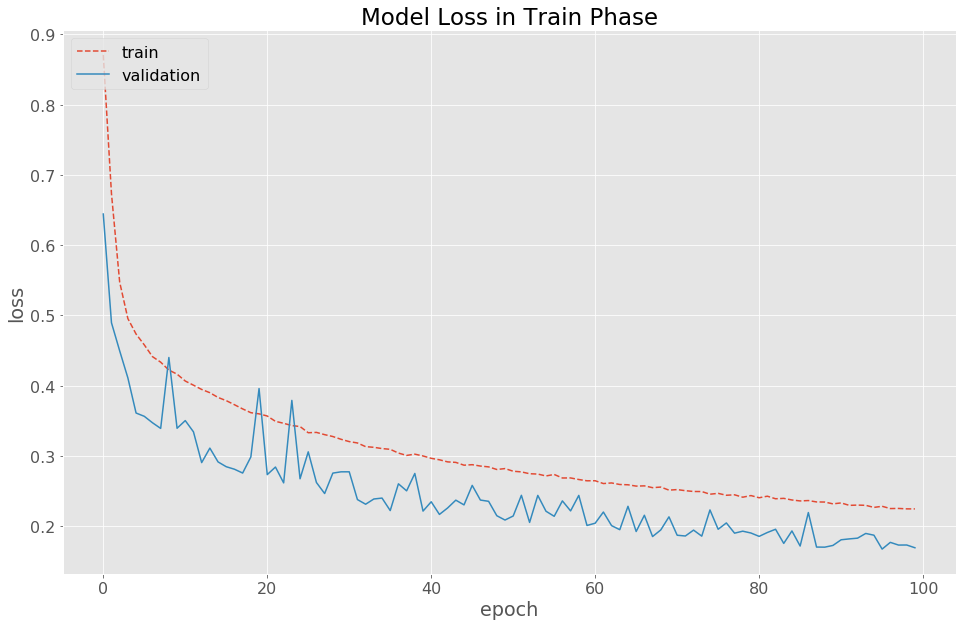

Creating model ./hdf5/1633364580945.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.67222, saving model to ./hdf5/1633364580945.hdf5
 - 3s - loss: 0.8871 - val_loss: 0.6722
Epoch 2/100
Epoch 00002: val_loss improved from 0.67222 to 0.53259, saving model to ./hdf5/1633364580945.hdf5
 - 2s - loss: 0.7073 - val_loss: 0.5326
Epoch 3/100
Epoch 00003: val_loss improved from 0.53259 to 0.43658, saving model to ./hdf5/1633364580945.hdf5
 - 2s - loss: 0.5724 - val_loss: 0.4366
Epoch 4/100
Epoch 00004: val_loss improved from 0.43658 to 0.39541, saving model to ./hdf5/1633364580945.hdf5
 - 2s - loss: 0.5049 - val_loss: 0.3954
Epoch 5/100
Epoch 00005: val_loss improved from 0.39541 to 0.37179, saving model to ./hdf5/1633364580945.hdf5
 - 2s - loss: 0.4725 - val_loss: 0.3718
Epoch 6/100
Epoch 00006: val_loss improved from 0.37179 to 0.36330, saving model to ./hdf5/1633364580945.hdf5
 - 2s - loss: 0.4521 - val_loss: 0.3633
Epoch 7/100
Ep

Epoch 00075: val_loss did not improve
 - 2s - loss: 0.2377 - val_loss: 0.1816
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2360 - val_loss: 0.1833
Epoch 77/100
Epoch 00077: val_loss improved from 0.17949 to 0.17735, saving model to ./hdf5/1633364580945.hdf5
 - 2s - loss: 0.2348 - val_loss: 0.1773
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 2s - loss: 0.2333 - val_loss: 0.1914
Epoch 79/100
Epoch 00079: val_loss did not improve
 - 2s - loss: 0.2328 - val_loss: 0.2193
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 1s - loss: 0.2331 - val_loss: 0.1937
Epoch 81/100
Epoch 00081: val_loss did not improve
 - 2s - loss: 0.2317 - val_loss: 0.1876
Epoch 82/100
Epoch 00082: val_loss did not improve
 - 2s - loss: 0.2315 - val_loss: 0.2475
Epoch 83/100
Epoch 00083: val_loss did not improve
 - 2s - loss: 0.2296 - val_loss: 0.2315
Epoch 84/100
Epoch 00084: val_loss did not improve
 - 1s - loss: 0.2274 - val_loss: 0.1809
Epoch 85/100
Epoch 00085: val_loss did not 

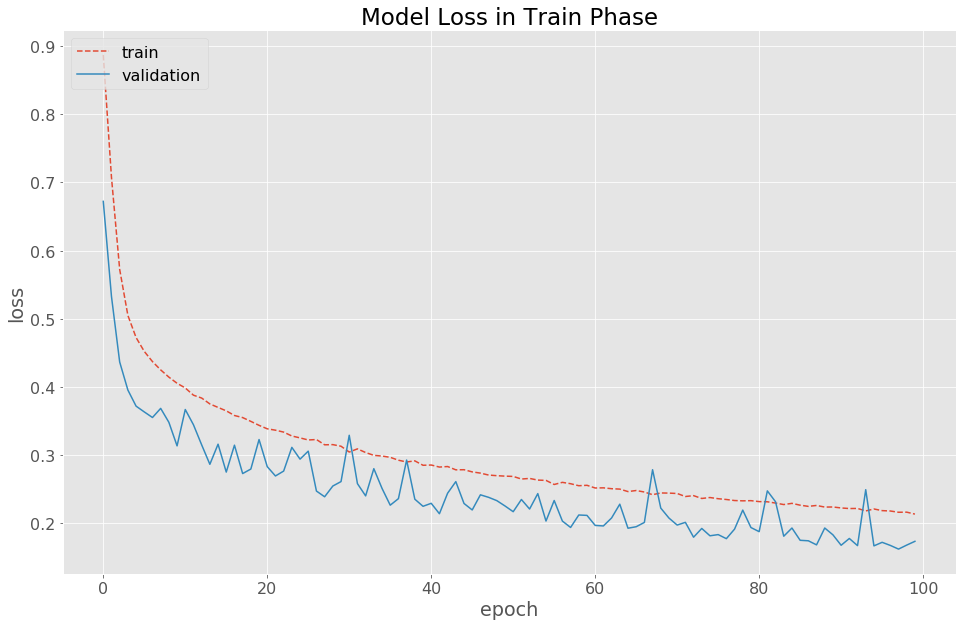

Creating model ./hdf5/1633086921027.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.67108, saving model to ./hdf5/1633086921027.hdf5
 - 3s - loss: 0.8041 - val_loss: 0.6711
Epoch 2/100
Epoch 00002: val_loss improved from 0.67108 to 0.56157, saving model to ./hdf5/1633086921027.hdf5
 - 2s - loss: 0.6271 - val_loss: 0.5616
Epoch 3/100
Epoch 00003: val_loss improved from 0.56157 to 0.50280, saving model to ./hdf5/1633086921027.hdf5
 - 2s - loss: 0.5362 - val_loss: 0.5028
Epoch 4/100
Epoch 00004: val_loss improved from 0.50280 to 0.46764, saving model to ./hdf5/1633086921027.hdf5
 - 2s - loss: 0.4975 - val_loss: 0.4676
Epoch 5/100
Epoch 00005: val_loss improved from 0.46764 to 0.45059, saving model to ./hdf5/1633086921027.hdf5
 - 2s - loss: 0.4689 - val_loss: 0.4506
Epoch 6/100
Epoch 00006: val_loss improved from 0.45059 to 0.40470, saving model to ./hdf5/1633086921027.hdf5
 - 2s - loss: 0.4473 - val_loss: 0.4047
Epoch 7/100
Ep

Epoch 00071: val_loss improved from 0.18129 to 0.17614, saving model to ./hdf5/1633086921027.hdf5
 - 2s - loss: 0.2238 - val_loss: 0.1761
Epoch 72/100
Epoch 00072: val_loss did not improve
 - 2s - loss: 0.2220 - val_loss: 0.2187
Epoch 73/100
Epoch 00073: val_loss did not improve
 - 2s - loss: 0.2238 - val_loss: 0.2311
Epoch 74/100
Epoch 00074: val_loss did not improve
 - 2s - loss: 0.2202 - val_loss: 0.2113
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 2s - loss: 0.2208 - val_loss: 0.1862
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2179 - val_loss: 0.2012
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 2s - loss: 0.2180 - val_loss: 0.2046
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 2s - loss: 0.2161 - val_loss: 0.2206
Epoch 79/100
Epoch 00079: val_loss did not improve
 - 2s - loss: 0.2153 - val_loss: 0.2477
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 2s - loss: 0.2147 - val_loss: 0.1880
Epoch 81/100
Epoch 00081: val_loss did not 

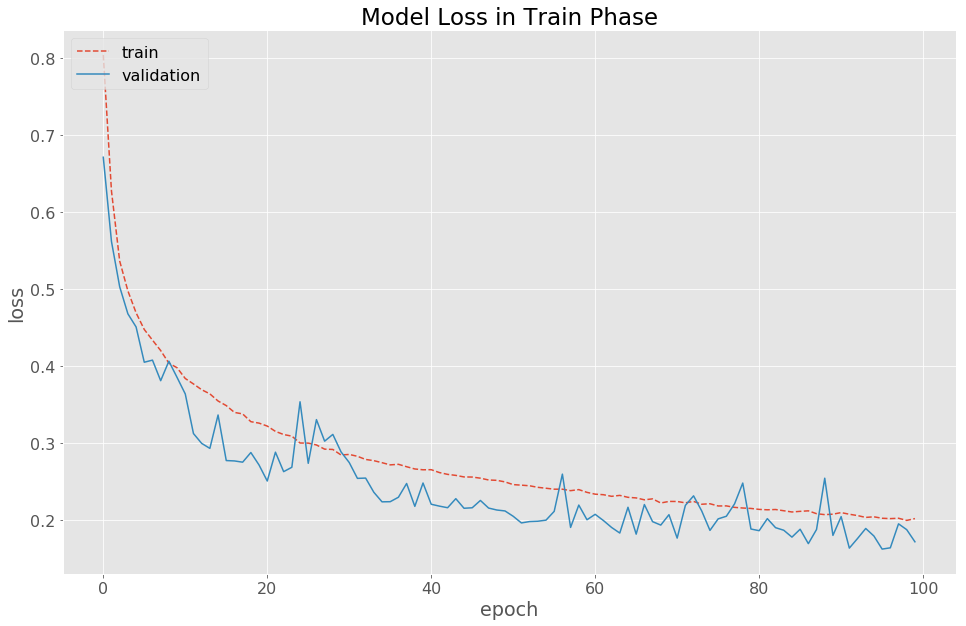

Creating model ./hdf5/2044717692178.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.70494, saving model to ./hdf5/2044717692178.hdf5
 - 3s - loss: 0.8653 - val_loss: 0.7049
Epoch 2/100
Epoch 00002: val_loss improved from 0.70494 to 0.58184, saving model to ./hdf5/2044717692178.hdf5
 - 2s - loss: 0.6943 - val_loss: 0.5818
Epoch 3/100
Epoch 00003: val_loss improved from 0.58184 to 0.50393, saving model to ./hdf5/2044717692178.hdf5
 - 2s - loss: 0.5780 - val_loss: 0.5039
Epoch 4/100
Epoch 00004: val_loss improved from 0.50393 to 0.47296, saving model to ./hdf5/2044717692178.hdf5
 - 2s - loss: 0.5218 - val_loss: 0.4730
Epoch 5/100
Epoch 00005: val_loss did not improve
 - 2s - loss: 0.4925 - val_loss: 0.4868
Epoch 6/100
Epoch 00006: val_loss improved from 0.47296 to 0.41950, saving model to ./hdf5/2044717692178.hdf5
 - 2s - loss: 0.4769 - val_loss: 0.4195
Epoch 7/100
Epoch 00007: val_loss did not improve
 - 2s - loss: 0.4651 - v

Epoch 74/100
Epoch 00074: val_loss did not improve
 - 2s - loss: 0.2622 - val_loss: 0.2514
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 2s - loss: 0.2620 - val_loss: 0.2504
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2596 - val_loss: 0.2338
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 2s - loss: 0.2606 - val_loss: 0.2685
Epoch 78/100
Epoch 00078: val_loss improved from 0.23355 to 0.22694, saving model to ./hdf5/2044717692178.hdf5
 - 2s - loss: 0.2573 - val_loss: 0.2269
Epoch 79/100
Epoch 00079: val_loss did not improve
 - 2s - loss: 0.2578 - val_loss: 0.2614
Epoch 80/100
Epoch 00080: val_loss improved from 0.22694 to 0.22317, saving model to ./hdf5/2044717692178.hdf5
 - 2s - loss: 0.2564 - val_loss: 0.2232
Epoch 81/100
Epoch 00081: val_loss did not improve
 - 2s - loss: 0.2530 - val_loss: 0.2768
Epoch 82/100
Epoch 00082: val_loss improved from 0.22317 to 0.22189, saving model to ./hdf5/2044717692178.hdf5
 - 2s - loss: 0.2556 - val_loss: 0.2219
E

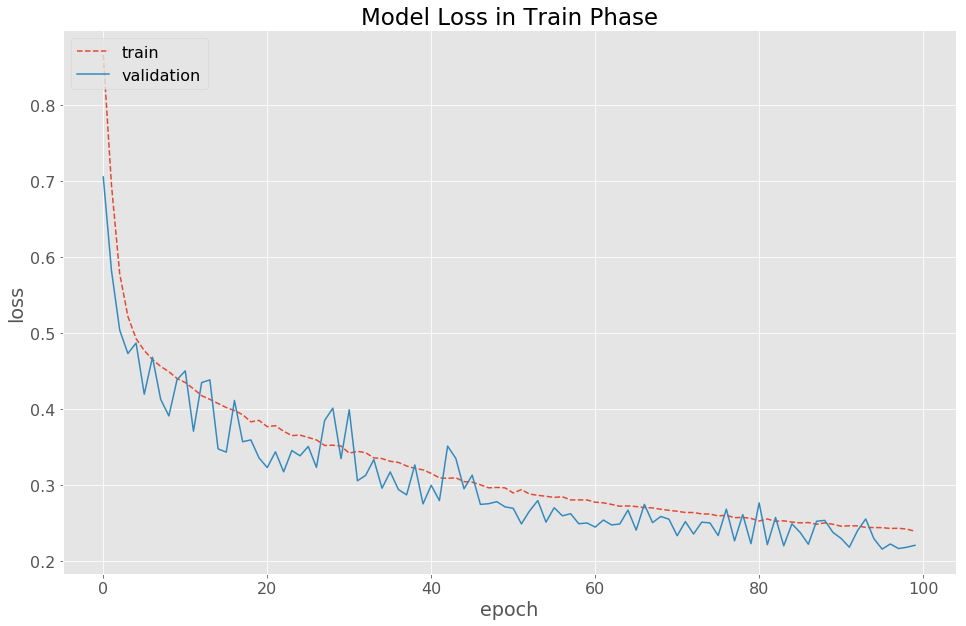

Creating model ./hdf5/1988253849303.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.73396, saving model to ./hdf5/1988253849303.hdf5
 - 3s - loss: 0.8632 - val_loss: 0.7340
Epoch 2/100
Epoch 00002: val_loss improved from 0.73396 to 0.56746, saving model to ./hdf5/1988253849303.hdf5
 - 2s - loss: 0.6744 - val_loss: 0.5675
Epoch 3/100
Epoch 00003: val_loss improved from 0.56746 to 0.48934, saving model to ./hdf5/1988253849303.hdf5
 - 2s - loss: 0.5531 - val_loss: 0.4893
Epoch 4/100
Epoch 00004: val_loss improved from 0.48934 to 0.47283, saving model to ./hdf5/1988253849303.hdf5
 - 2s - loss: 0.5083 - val_loss: 0.4728
Epoch 5/100
Epoch 00005: val_loss did not improve
 - 2s - loss: 0.4799 - val_loss: 0.4761
Epoch 6/100
Epoch 00006: val_loss improved from 0.47283 to 0.42320, saving model to ./hdf5/1988253849303.hdf5
 - 2s - loss: 0.4727 - val_loss: 0.4232
Epoch 7/100
Epoch 00007: val_loss improved from 0.42320 to 0.40925, saving

Epoch 72/100
Epoch 00072: val_loss did not improve
 - 2s - loss: 0.2697 - val_loss: 0.2556
Epoch 73/100
Epoch 00073: val_loss improved from 0.24395 to 0.24136, saving model to ./hdf5/1988253849303.hdf5
 - 2s - loss: 0.2684 - val_loss: 0.2414
Epoch 74/100
Epoch 00074: val_loss improved from 0.24136 to 0.24067, saving model to ./hdf5/1988253849303.hdf5
 - 2s - loss: 0.2695 - val_loss: 0.2407
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 2s - loss: 0.2658 - val_loss: 0.2472
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2650 - val_loss: 0.2497
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 2s - loss: 0.2640 - val_loss: 0.2605
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 2s - loss: 0.2629 - val_loss: 0.2563
Epoch 79/100
Epoch 00079: val_loss did not improve
 - 2s - loss: 0.2629 - val_loss: 0.2864
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 2s - loss: 0.2612 - val_loss: 0.2424
Epoch 81/100
Epoch 00081: val_loss did not improve
 - 2s - lo

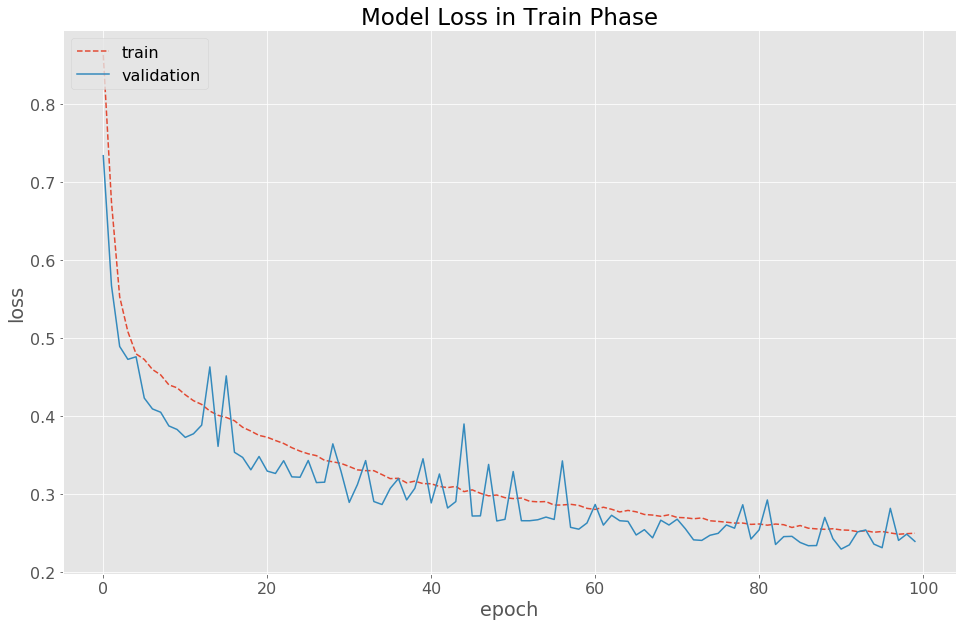

Creating model ./hdf5/1218393902411.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.66851, saving model to ./hdf5/1218393902411.hdf5
 - 3s - loss: 0.8303 - val_loss: 0.6685
Epoch 2/100
Epoch 00002: val_loss improved from 0.66851 to 0.51175, saving model to ./hdf5/1218393902411.hdf5
 - 2s - loss: 0.6437 - val_loss: 0.5118
Epoch 3/100
Epoch 00003: val_loss improved from 0.51175 to 0.44191, saving model to ./hdf5/1218393902411.hdf5
 - 2s - loss: 0.5095 - val_loss: 0.4419
Epoch 4/100
Epoch 00004: val_loss improved from 0.44191 to 0.39743, saving model to ./hdf5/1218393902411.hdf5
 - 2s - loss: 0.4683 - val_loss: 0.3974
Epoch 5/100
Epoch 00005: val_loss improved from 0.39743 to 0.38907, saving model to ./hdf5/1218393902411.hdf5
 - 2s - loss: 0.4489 - val_loss: 0.3891
Epoch 6/100
Epoch 00006: val_loss improved from 0.38907 to 0.37867, saving model to ./hdf5/1218393902411.hdf5
 - 2s - loss: 0.4383 - val_loss: 0.3787
Epoch 7/100
Ep

Epoch 71/100
Epoch 00071: val_loss did not improve
 - 2s - loss: 0.2231 - val_loss: 0.1856
Epoch 72/100
Epoch 00072: val_loss did not improve
 - 2s - loss: 0.2227 - val_loss: 0.2015
Epoch 73/100
Epoch 00073: val_loss did not improve
 - 2s - loss: 0.2210 - val_loss: 0.1826
Epoch 74/100
Epoch 00074: val_loss did not improve
 - 2s - loss: 0.2207 - val_loss: 0.2035
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 2s - loss: 0.2193 - val_loss: 0.1957
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2211 - val_loss: 0.1869
Epoch 77/100
Epoch 00077: val_loss improved from 0.17900 to 0.17871, saving model to ./hdf5/1218393902411.hdf5
 - 2s - loss: 0.2173 - val_loss: 0.1787
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 2s - loss: 0.2188 - val_loss: 0.1830
Epoch 79/100
Epoch 00079: val_loss did not improve
 - 2s - loss: 0.2168 - val_loss: 0.1846
Epoch 80/100
Epoch 00080: val_loss improved from 0.17871 to 0.16989, saving model to ./hdf5/1218393902411.hdf5
 - 2s - lo

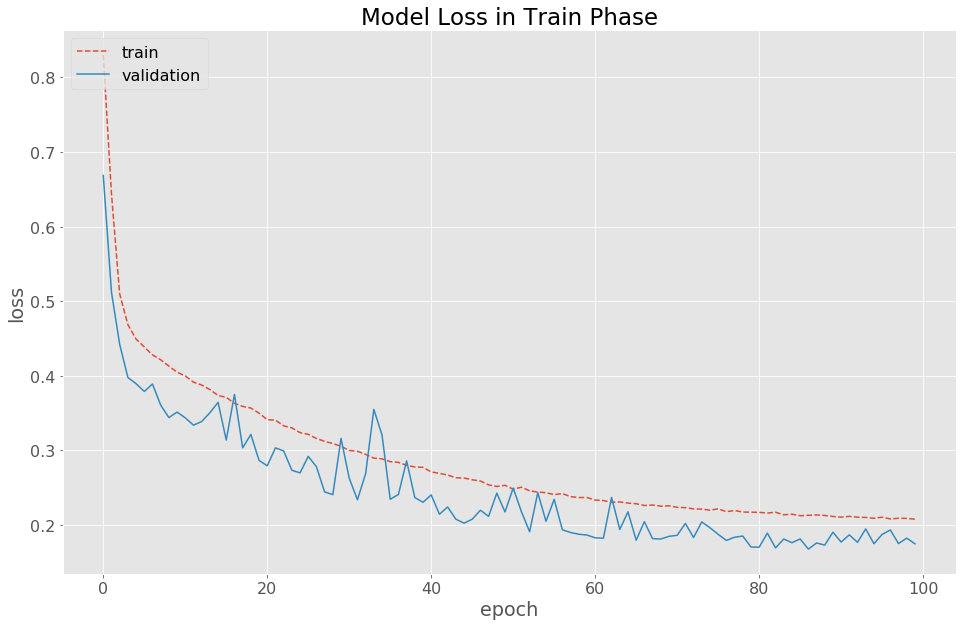

Creating model ./hdf5/1287209484750.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.71657, saving model to ./hdf5/1287209484750.hdf5
 - 4s - loss: 0.8737 - val_loss: 0.7166
Epoch 2/100
Epoch 00002: val_loss improved from 0.71657 to 0.61110, saving model to ./hdf5/1287209484750.hdf5
 - 2s - loss: 0.7063 - val_loss: 0.6111
Epoch 3/100
Epoch 00003: val_loss improved from 0.61110 to 0.51187, saving model to ./hdf5/1287209484750.hdf5
 - 2s - loss: 0.6030 - val_loss: 0.5119
Epoch 4/100
Epoch 00004: val_loss improved from 0.51187 to 0.46604, saving model to ./hdf5/1287209484750.hdf5
 - 2s - loss: 0.5386 - val_loss: 0.4660
Epoch 5/100
Epoch 00005: val_loss improved from 0.46604 to 0.43466, saving model to ./hdf5/1287209484750.hdf5
 - 2s - loss: 0.5076 - val_loss: 0.4347
Epoch 6/100
Epoch 00006: val_loss did not improve
 - 2s - loss: 0.4919 - val_loss: 0.4672
Epoch 7/100
Epoch 00007: val_loss improved from 0.43466 to 0.40345, saving

Epoch 74/100
Epoch 00074: val_loss did not improve
 - 2s - loss: 0.2812 - val_loss: 0.2611
Epoch 75/100
Epoch 00075: val_loss improved from 0.23867 to 0.23212, saving model to ./hdf5/1287209484750.hdf5
 - 2s - loss: 0.2801 - val_loss: 0.2321
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2789 - val_loss: 0.2468
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 2s - loss: 0.2776 - val_loss: 0.2482
Epoch 78/100
Epoch 00078: val_loss improved from 0.23212 to 0.23154, saving model to ./hdf5/1287209484750.hdf5
 - 2s - loss: 0.2784 - val_loss: 0.2315
Epoch 79/100
Epoch 00079: val_loss did not improve
 - 2s - loss: 0.2765 - val_loss: 0.2685
Epoch 80/100
Epoch 00080: val_loss improved from 0.23154 to 0.22767, saving model to ./hdf5/1287209484750.hdf5
 - 2s - loss: 0.2740 - val_loss: 0.2277
Epoch 81/100
Epoch 00081: val_loss improved from 0.22767 to 0.22589, saving model to ./hdf5/1287209484750.hdf5
 - 2s - loss: 0.2759 - val_loss: 0.2259
Epoch 82/100
Epoch 00082: val_lo

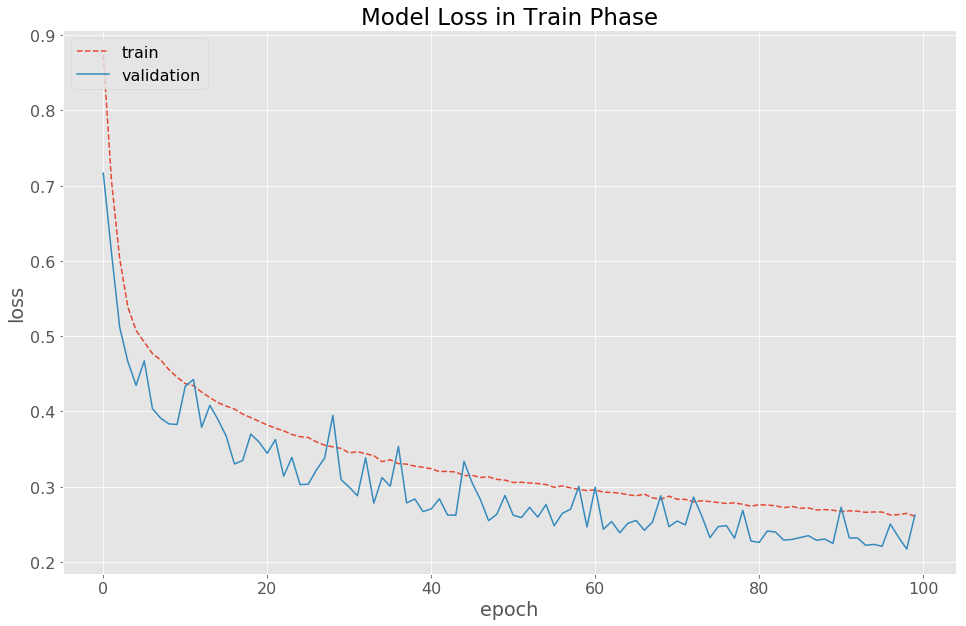

Creating model ./hdf5/2021410259189.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.68548, saving model to ./hdf5/2021410259189.hdf5
 - 3s - loss: 0.8837 - val_loss: 0.6855
Epoch 2/100
Epoch 00002: val_loss improved from 0.68548 to 0.51993, saving model to ./hdf5/2021410259189.hdf5
 - 2s - loss: 0.6846 - val_loss: 0.5199
Epoch 3/100
Epoch 00003: val_loss improved from 0.51993 to 0.45063, saving model to ./hdf5/2021410259189.hdf5
 - 2s - loss: 0.5482 - val_loss: 0.4506
Epoch 4/100
Epoch 00004: val_loss improved from 0.45063 to 0.41200, saving model to ./hdf5/2021410259189.hdf5
 - 2s - loss: 0.5064 - val_loss: 0.4120
Epoch 5/100
Epoch 00005: val_loss improved from 0.41200 to 0.40240, saving model to ./hdf5/2021410259189.hdf5
 - 2s - loss: 0.4842 - val_loss: 0.4024
Epoch 6/100
Epoch 00006: val_loss did not improve
 - 2s - loss: 0.4758 - val_loss: 0.4324
Epoch 7/100
Epoch 00007: val_loss did not improve
 - 2s - loss: 0.4637 - v

Epoch 00073: val_loss did not improve
 - 2s - loss: 0.2823 - val_loss: 0.2678
Epoch 74/100
Epoch 00074: val_loss did not improve
 - 2s - loss: 0.2819 - val_loss: 0.2360
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 2s - loss: 0.2789 - val_loss: 0.2461
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2789 - val_loss: 0.2407
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 2s - loss: 0.2794 - val_loss: 0.2386
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 2s - loss: 0.2757 - val_loss: 0.2388
Epoch 79/100
Epoch 00079: val_loss improved from 0.23385 to 0.22596, saving model to ./hdf5/2021410259189.hdf5
 - 2s - loss: 0.2775 - val_loss: 0.2260
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 2s - loss: 0.2735 - val_loss: 0.2370
Epoch 81/100
Epoch 00081: val_loss did not improve
 - 2s - loss: 0.2738 - val_loss: 0.2453
Epoch 82/100
Epoch 00082: val_loss did not improve
 - 2s - loss: 0.2745 - val_loss: 0.2315
Epoch 83/100
Epoch 00083: val_loss did not 

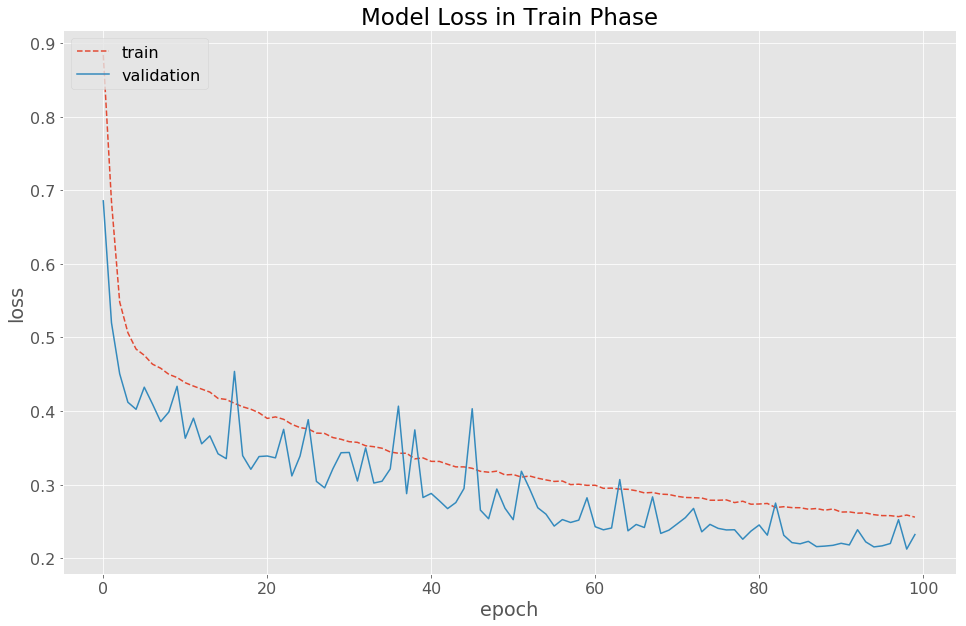

In [10]:
results_middles = all_places(selected_middle_of_roads, NN_TYPE + '_middles')

In [11]:
results_middles

,simple_lstm_only_speeds
stat,
corr,0.838996
mae,2.554312
r2,0.699353
rmse,4.579491


Creating model ./hdf5/1919180236832.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.67359, saving model to ./hdf5/1919180236832.hdf5
 - 4s - loss: 0.8800 - val_loss: 0.6736
Epoch 2/100
Epoch 00002: val_loss improved from 0.67359 to 0.57673, saving model to ./hdf5/1919180236832.hdf5
 - 2s - loss: 0.6938 - val_loss: 0.5767
Epoch 3/100
Epoch 00003: val_loss improved from 0.57673 to 0.48566, saving model to ./hdf5/1919180236832.hdf5
 - 2s - loss: 0.5847 - val_loss: 0.4857
Epoch 4/100
Epoch 00004: val_loss improved from 0.48566 to 0.45067, saving model to ./hdf5/1919180236832.hdf5
 - 2s - loss: 0.5297 - val_loss: 0.4507
Epoch 5/100
Epoch 00005: val_loss improved from 0.45067 to 0.42877, saving model to ./hdf5/1919180236832.hdf5
 - 2s - loss: 0.5052 - val_loss: 0.4288
Epoch 6/100
Epoch 00006: val_loss did not improve
 - 2s - loss: 0.4899 - val_loss: 0.4900
Epoch 7/100
Epoch 00007: val_loss improved from 0.42877 to 0.40023, saving

Epoch 73/100
Epoch 00073: val_loss did not improve
 - 2s - loss: 0.2621 - val_loss: 0.2465
Epoch 74/100
Epoch 00074: val_loss improved from 0.22249 to 0.22200, saving model to ./hdf5/1919180236832.hdf5
 - 2s - loss: 0.2626 - val_loss: 0.2220
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 2s - loss: 0.2614 - val_loss: 0.2333
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2595 - val_loss: 0.2257
Epoch 77/100
Epoch 00077: val_loss improved from 0.22200 to 0.21682, saving model to ./hdf5/1919180236832.hdf5
 - 2s - loss: 0.2606 - val_loss: 0.2168
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 2s - loss: 0.2584 - val_loss: 0.2432
Epoch 79/100
Epoch 00079: val_loss did not improve
 - 2s - loss: 0.2576 - val_loss: 0.2215
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 2s - loss: 0.2560 - val_loss: 0.2220
Epoch 81/100
Epoch 00081: val_loss did not improve
 - 2s - loss: 0.2574 - val_loss: 0.2506
Epoch 82/100
Epoch 00082: val_loss did not improve
 - 2s - lo

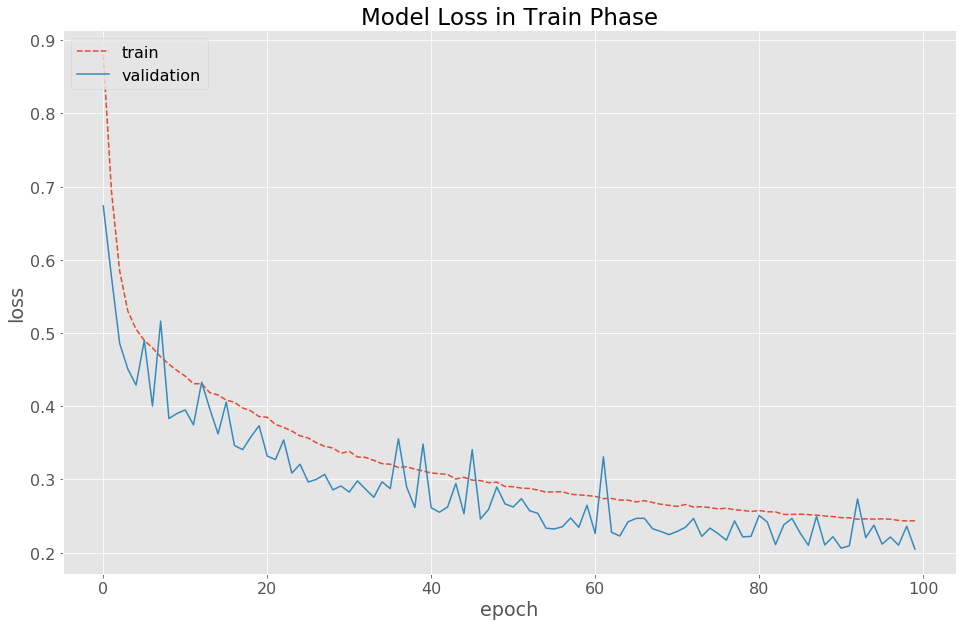

Creating model ./hdf5/1323625462547.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.72025, saving model to ./hdf5/1323625462547.hdf5
 - 4s - loss: 0.9271 - val_loss: 0.7202
Epoch 2/100
Epoch 00002: val_loss improved from 0.72025 to 0.59498, saving model to ./hdf5/1323625462547.hdf5
 - 2s - loss: 0.7489 - val_loss: 0.5950
Epoch 3/100
Epoch 00003: val_loss improved from 0.59498 to 0.51818, saving model to ./hdf5/1323625462547.hdf5
 - 2s - loss: 0.6316 - val_loss: 0.5182
Epoch 4/100
Epoch 00004: val_loss did not improve
 - 2s - loss: 0.5848 - val_loss: 0.5364
Epoch 5/100
Epoch 00005: val_loss improved from 0.51818 to 0.48287, saving model to ./hdf5/1323625462547.hdf5
 - 2s - loss: 0.5657 - val_loss: 0.4829
Epoch 6/100
Epoch 00006: val_loss did not improve
 - 2s - loss: 0.5533 - val_loss: 0.4870
Epoch 7/100
Epoch 00007: val_loss improved from 0.48287 to 0.46757, saving model to ./hdf5/1323625462547.hdf5
 - 2s - loss: 0.5423 - v

Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.4242 - val_loss: 0.3995
Epoch 77/100
Epoch 00077: val_loss improved from 0.38551 to 0.38430, saving model to ./hdf5/1323625462547.hdf5
 - 2s - loss: 0.4266 - val_loss: 0.3843
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 2s - loss: 0.4232 - val_loss: 0.3861
Epoch 79/100
Epoch 00079: val_loss did not improve
 - 2s - loss: 0.4228 - val_loss: 0.3898
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 2s - loss: 0.4231 - val_loss: 0.3970
Epoch 81/100
Epoch 00081: val_loss improved from 0.38430 to 0.38326, saving model to ./hdf5/1323625462547.hdf5
 - 2s - loss: 0.4222 - val_loss: 0.3833
Epoch 82/100
Epoch 00082: val_loss did not improve
 - 2s - loss: 0.4217 - val_loss: 0.4025
Epoch 83/100
Epoch 00083: val_loss did not improve
 - 2s - loss: 0.4203 - val_loss: 0.3859
Epoch 84/100
Epoch 00084: val_loss did not improve
 - 2s - loss: 0.4200 - val_loss: 0.3926
Epoch 85/100
Epoch 00085: val_loss did not improve
 - 2s - lo

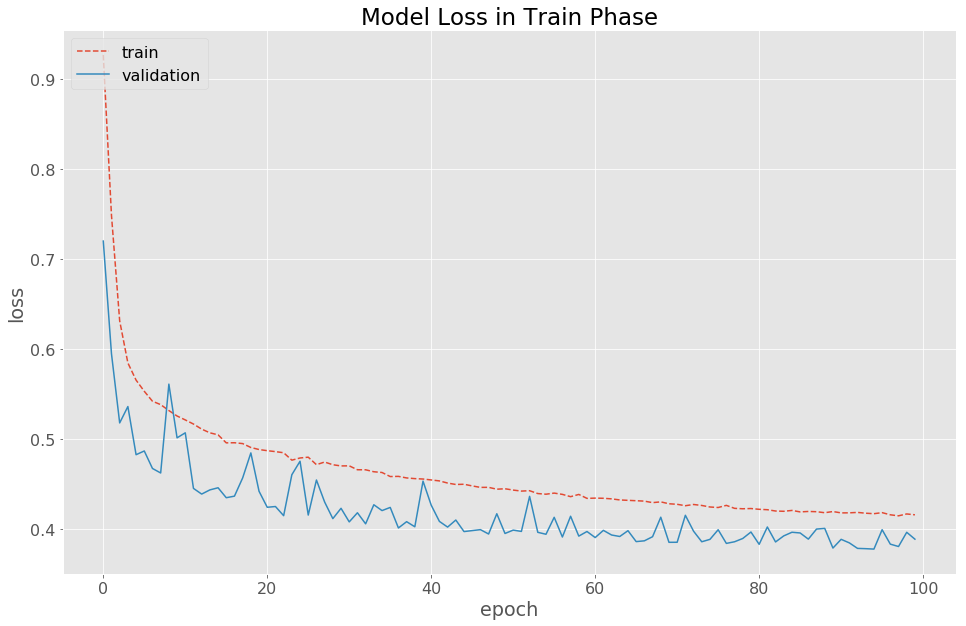

Creating model ./hdf5/1360034198240.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.74033, saving model to ./hdf5/1360034198240.hdf5
 - 4s - loss: 0.8872 - val_loss: 0.7403
Epoch 2/100
Epoch 00002: val_loss improved from 0.74033 to 0.60733, saving model to ./hdf5/1360034198240.hdf5
 - 2s - loss: 0.7177 - val_loss: 0.6073
Epoch 3/100
Epoch 00003: val_loss improved from 0.60733 to 0.60189, saving model to ./hdf5/1360034198240.hdf5
 - 2s - loss: 0.6183 - val_loss: 0.6019
Epoch 4/100
Epoch 00004: val_loss improved from 0.60189 to 0.51628, saving model to ./hdf5/1360034198240.hdf5
 - 2s - loss: 0.5745 - val_loss: 0.5163
Epoch 5/100
Epoch 00005: val_loss improved from 0.51628 to 0.48494, saving model to ./hdf5/1360034198240.hdf5
 - 2s - loss: 0.5442 - val_loss: 0.4849
Epoch 6/100
Epoch 00006: val_loss did not improve
 - 2s - loss: 0.5208 - val_loss: 0.4863
Epoch 7/100
Epoch 00007: val_loss improved from 0.48494 to 0.44601, saving

Epoch 74/100
Epoch 00074: val_loss did not improve
 - 2s - loss: 0.3573 - val_loss: 0.3243
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 2s - loss: 0.3555 - val_loss: 0.3223
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.3549 - val_loss: 0.3261
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 2s - loss: 0.3570 - val_loss: 0.3212
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 2s - loss: 0.3552 - val_loss: 0.3465
Epoch 79/100
Epoch 00079: val_loss improved from 0.31873 to 0.31518, saving model to ./hdf5/1360034198240.hdf5
 - 2s - loss: 0.3538 - val_loss: 0.3152
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 2s - loss: 0.3548 - val_loss: 0.3525
Epoch 81/100
Epoch 00081: val_loss did not improve
 - 2s - loss: 0.3530 - val_loss: 0.3208
Epoch 82/100
Epoch 00082: val_loss did not improve
 - 2s - loss: 0.3536 - val_loss: 0.3259
Epoch 83/100
Epoch 00083: val_loss did not improve
 - 2s - loss: 0.3521 - val_loss: 0.3254
Epoch 84/100
Epoch 00084: val_

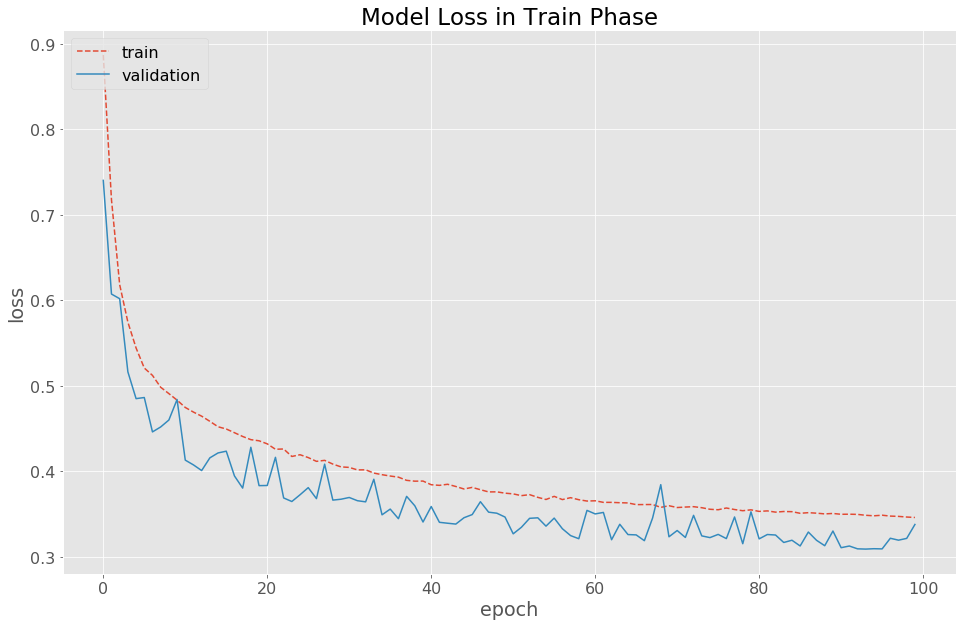

Creating model ./hdf5/1523744717011.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.83290, saving model to ./hdf5/1523744717011.hdf5
 - 4s - loss: 0.9186 - val_loss: 0.8329
Epoch 2/100
Epoch 00002: val_loss improved from 0.83290 to 0.68338, saving model to ./hdf5/1523744717011.hdf5
 - 2s - loss: 0.7462 - val_loss: 0.6834
Epoch 3/100
Epoch 00003: val_loss improved from 0.68338 to 0.60986, saving model to ./hdf5/1523744717011.hdf5
 - 2s - loss: 0.6303 - val_loss: 0.6099
Epoch 4/100
Epoch 00004: val_loss improved from 0.60986 to 0.56342, saving model to ./hdf5/1523744717011.hdf5
 - 2s - loss: 0.5743 - val_loss: 0.5634
Epoch 5/100
Epoch 00005: val_loss improved from 0.56342 to 0.54409, saving model to ./hdf5/1523744717011.hdf5
 - 2s - loss: 0.5441 - val_loss: 0.5441
Epoch 6/100
Epoch 00006: val_loss did not improve
 - 2s - loss: 0.5229 - val_loss: 0.5895
Epoch 7/100
Epoch 00007: val_loss improved from 0.54409 to 0.50680, saving

Epoch 72/100
Epoch 00072: val_loss did not improve
 - 2s - loss: 0.3894 - val_loss: 0.4004
Epoch 73/100
Epoch 00073: val_loss did not improve
 - 2s - loss: 0.3895 - val_loss: 0.3995
Epoch 74/100
Epoch 00074: val_loss improved from 0.38999 to 0.38756, saving model to ./hdf5/1523744717011.hdf5
 - 2s - loss: 0.3882 - val_loss: 0.3876
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 2s - loss: 0.3884 - val_loss: 0.3967
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.3869 - val_loss: 0.4003
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 2s - loss: 0.3879 - val_loss: 0.3946
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 2s - loss: 0.3852 - val_loss: 0.3904
Epoch 79/100
Epoch 00079: val_loss did not improve
 - 2s - loss: 0.3866 - val_loss: 0.3885
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 2s - loss: 0.3856 - val_loss: 0.3989
Epoch 81/100
Epoch 00081: val_loss improved from 0.38756 to 0.38710, saving model to ./hdf5/1523744717011.hdf5
 - 2s - lo

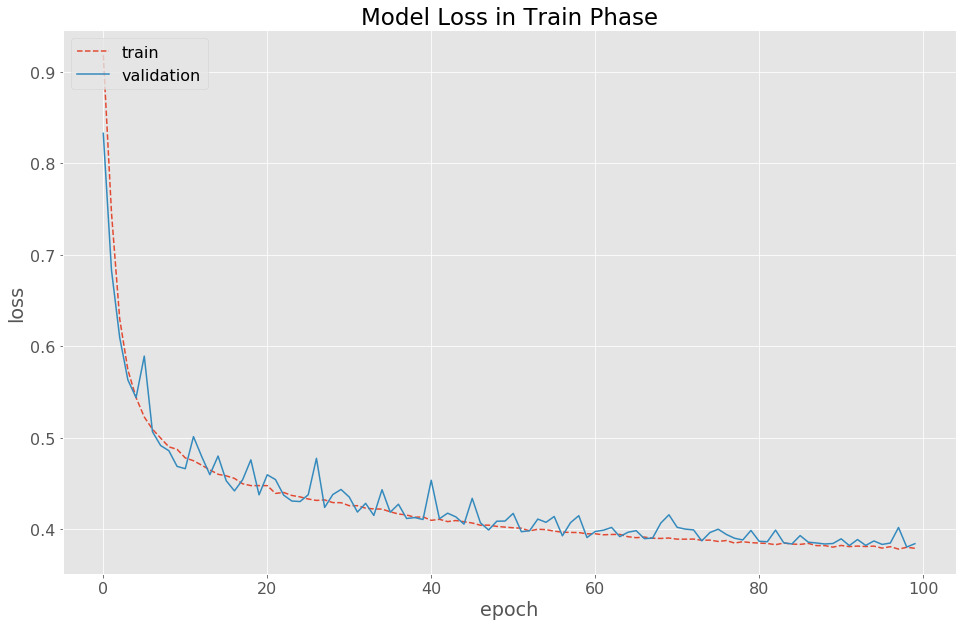

Creating model ./hdf5/1373044405622.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.81241, saving model to ./hdf5/1373044405622.hdf5
 - 4s - loss: 0.8659 - val_loss: 0.8124
Epoch 2/100
Epoch 00002: val_loss improved from 0.81241 to 0.66953, saving model to ./hdf5/1373044405622.hdf5
 - 2s - loss: 0.7007 - val_loss: 0.6695
Epoch 3/100
Epoch 00003: val_loss improved from 0.66953 to 0.56746, saving model to ./hdf5/1373044405622.hdf5
 - 2s - loss: 0.5879 - val_loss: 0.5675
Epoch 4/100
Epoch 00004: val_loss improved from 0.56746 to 0.55043, saving model to ./hdf5/1373044405622.hdf5
 - 2s - loss: 0.5276 - val_loss: 0.5504
Epoch 5/100
Epoch 00005: val_loss improved from 0.55043 to 0.52759, saving model to ./hdf5/1373044405622.hdf5
 - 2s - loss: 0.4991 - val_loss: 0.5276
Epoch 6/100
Epoch 00006: val_loss improved from 0.52759 to 0.47130, saving model to ./hdf5/1373044405622.hdf5
 - 2s - loss: 0.4800 - val_loss: 0.4713
Epoch 7/100
Ep

Epoch 74/100
Epoch 00074: val_loss did not improve
 - 2s - loss: 0.2730 - val_loss: 0.2796
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 2s - loss: 0.2705 - val_loss: 0.2829
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2718 - val_loss: 0.2840
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 2s - loss: 0.2709 - val_loss: 0.2920
Epoch 78/100
Epoch 00078: val_loss improved from 0.27560 to 0.27320, saving model to ./hdf5/1373044405622.hdf5
 - 2s - loss: 0.2702 - val_loss: 0.2732
Epoch 79/100
Epoch 00079: val_loss improved from 0.27320 to 0.26708, saving model to ./hdf5/1373044405622.hdf5
 - 2s - loss: 0.2653 - val_loss: 0.2671
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 2s - loss: 0.2682 - val_loss: 0.2830
Epoch 81/100
Epoch 00081: val_loss did not improve
 - 2s - loss: 0.2656 - val_loss: 0.2685
Epoch 82/100
Epoch 00082: val_loss did not improve
 - 2s - loss: 0.2646 - val_loss: 0.2747
Epoch 83/100
Epoch 00083: val_loss did not improve
 - 2s - lo

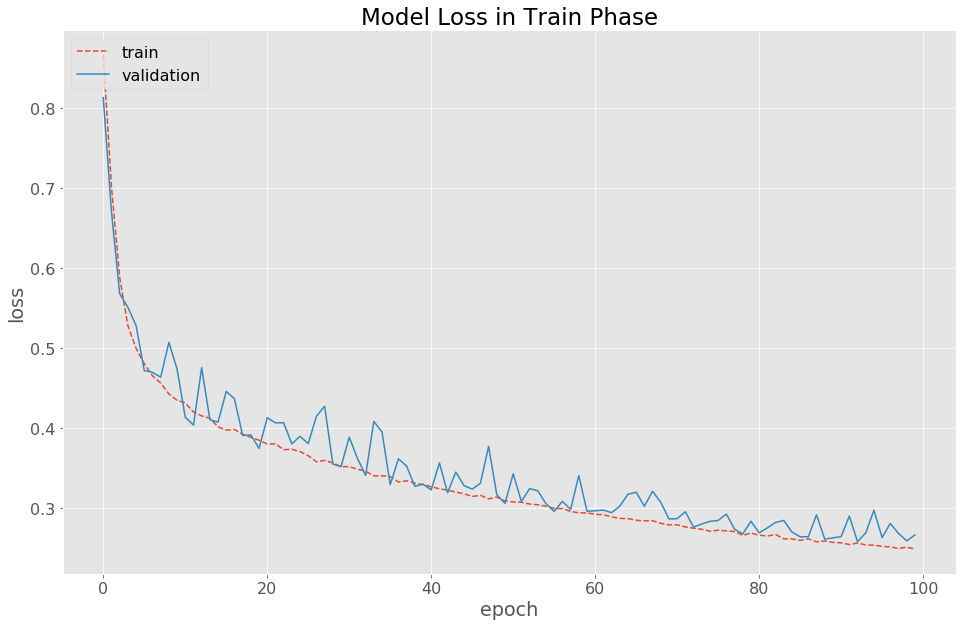

Creating model ./hdf5/2095599624712.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.81831, saving model to ./hdf5/2095599624712.hdf5
 - 4s - loss: 0.9518 - val_loss: 0.8183
Epoch 2/100
Epoch 00002: val_loss improved from 0.81831 to 0.66130, saving model to ./hdf5/2095599624712.hdf5
 - 2s - loss: 0.7738 - val_loss: 0.6613
Epoch 3/100
Epoch 00003: val_loss improved from 0.66130 to 0.55382, saving model to ./hdf5/2095599624712.hdf5
 - 2s - loss: 0.6403 - val_loss: 0.5538
Epoch 4/100
Epoch 00004: val_loss improved from 0.55382 to 0.51347, saving model to ./hdf5/2095599624712.hdf5
 - 2s - loss: 0.5795 - val_loss: 0.5135
Epoch 5/100
Epoch 00005: val_loss improved from 0.51347 to 0.49868, saving model to ./hdf5/2095599624712.hdf5
 - 2s - loss: 0.5551 - val_loss: 0.4987
Epoch 6/100
Epoch 00006: val_loss did not improve
 - 2s - loss: 0.5342 - val_loss: 0.5643
Epoch 7/100
Epoch 00007: val_loss improved from 0.49868 to 0.46267, saving

Epoch 73/100
Epoch 00073: val_loss improved from 0.35591 to 0.35452, saving model to ./hdf5/2095599624712.hdf5
 - 2s - loss: 0.3958 - val_loss: 0.3545
Epoch 74/100
Epoch 00074: val_loss did not improve
 - 2s - loss: 0.3946 - val_loss: 0.3561
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 2s - loss: 0.3942 - val_loss: 0.3742
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.3932 - val_loss: 0.3576
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 2s - loss: 0.3918 - val_loss: 0.3548
Epoch 78/100
Epoch 00078: val_loss improved from 0.35452 to 0.35233, saving model to ./hdf5/2095599624712.hdf5
 - 2s - loss: 0.3933 - val_loss: 0.3523
Epoch 79/100
Epoch 00079: val_loss did not improve
 - 2s - loss: 0.3926 - val_loss: 0.3538
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 2s - loss: 0.3903 - val_loss: 0.3566
Epoch 81/100
Epoch 00081: val_loss did not improve
 - 2s - loss: 0.3898 - val_loss: 0.3542
Epoch 82/100
Epoch 00082: val_loss did not improve
 - 2s - lo

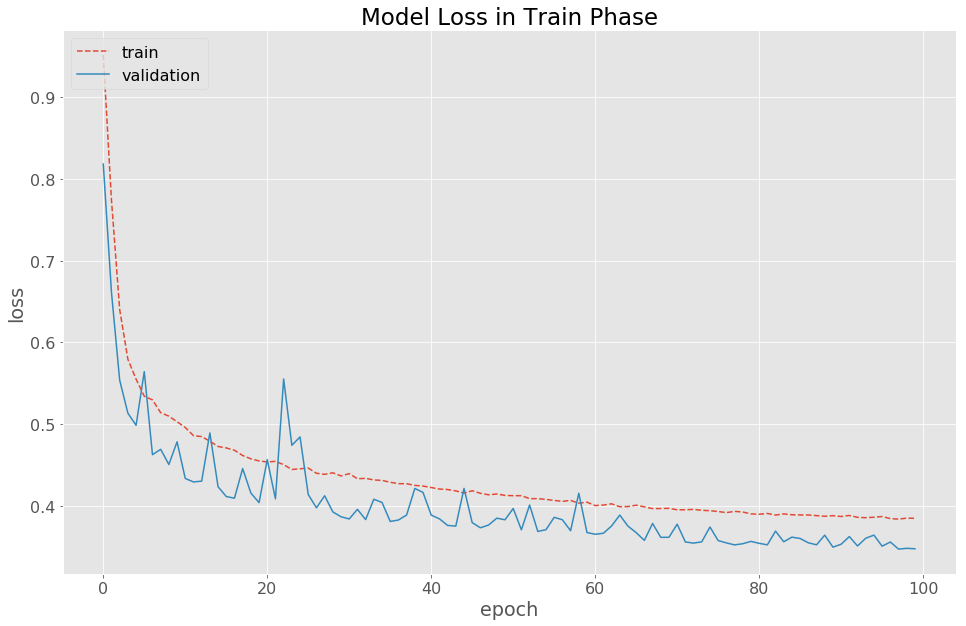

Creating model ./hdf5/1827170297681.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.71348, saving model to ./hdf5/1827170297681.hdf5
 - 4s - loss: 0.8660 - val_loss: 0.7135
Epoch 2/100
Epoch 00002: val_loss improved from 0.71348 to 0.59501, saving model to ./hdf5/1827170297681.hdf5
 - 2s - loss: 0.7015 - val_loss: 0.5950
Epoch 3/100
Epoch 00003: val_loss improved from 0.59501 to 0.53515, saving model to ./hdf5/1827170297681.hdf5
 - 2s - loss: 0.5955 - val_loss: 0.5351
Epoch 4/100
Epoch 00004: val_loss improved from 0.53515 to 0.51712, saving model to ./hdf5/1827170297681.hdf5
 - 2s - loss: 0.5347 - val_loss: 0.5171
Epoch 5/100
Epoch 00005: val_loss improved from 0.51712 to 0.47868, saving model to ./hdf5/1827170297681.hdf5
 - 2s - loss: 0.5144 - val_loss: 0.4787
Epoch 6/100
Epoch 00006: val_loss did not improve
 - 2s - loss: 0.4975 - val_loss: 0.4965
Epoch 7/100
Epoch 00007: val_loss improved from 0.47868 to 0.45100, saving

Epoch 73/100
Epoch 00073: val_loss did not improve
 - 2s - loss: 0.2793 - val_loss: 0.2910
Epoch 74/100
Epoch 00074: val_loss did not improve
 - 2s - loss: 0.2784 - val_loss: 0.2556
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 2s - loss: 0.2773 - val_loss: 0.2622
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2766 - val_loss: 0.2573
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 2s - loss: 0.2760 - val_loss: 0.2614
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 2s - loss: 0.2719 - val_loss: 0.2868
Epoch 79/100
Epoch 00079: val_loss improved from 0.25360 to 0.25187, saving model to ./hdf5/1827170297681.hdf5
 - 2s - loss: 0.2737 - val_loss: 0.2519
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 2s - loss: 0.2720 - val_loss: 0.2533
Epoch 81/100
Epoch 00081: val_loss did not improve
 - 2s - loss: 0.2736 - val_loss: 0.2576
Epoch 82/100
Epoch 00082: val_loss improved from 0.25187 to 0.24599, saving model to ./hdf5/1827170297681.hdf5
 - 2s - lo

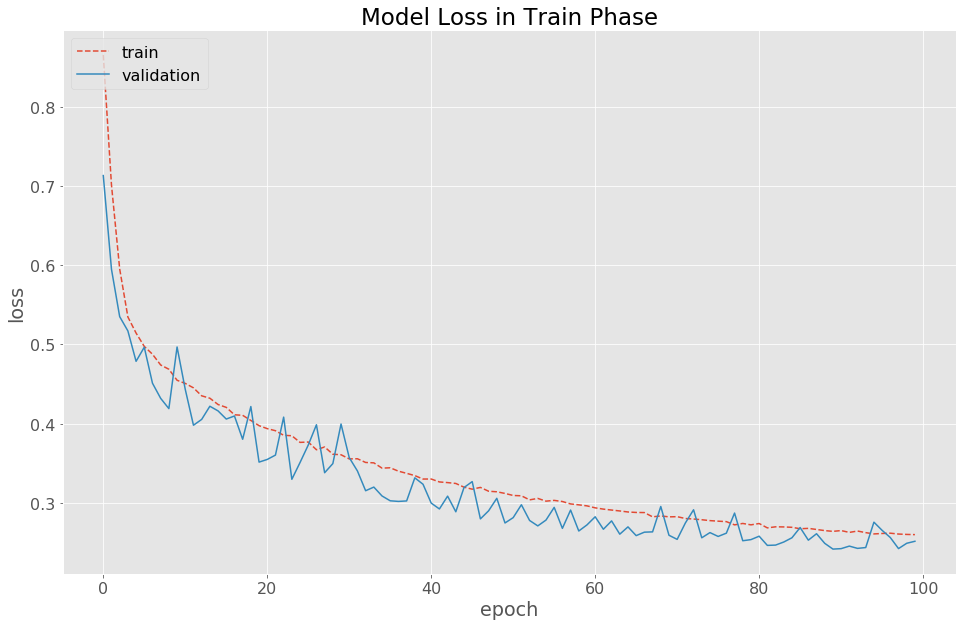

Creating model ./hdf5/2013667817026.hdf5
Train on 34780 samples, validate on 8695 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.73888, saving model to ./hdf5/2013667817026.hdf5
 - 4s - loss: 0.8859 - val_loss: 0.7389
Epoch 2/100
Epoch 00002: val_loss improved from 0.73888 to 0.61570, saving model to ./hdf5/2013667817026.hdf5
 - 2s - loss: 0.7133 - val_loss: 0.6157
Epoch 3/100
Epoch 00003: val_loss improved from 0.61570 to 0.53578, saving model to ./hdf5/2013667817026.hdf5
 - 2s - loss: 0.6065 - val_loss: 0.5358
Epoch 4/100
Epoch 00004: val_loss improved from 0.53578 to 0.49253, saving model to ./hdf5/2013667817026.hdf5
 - 2s - loss: 0.5553 - val_loss: 0.4925
Epoch 5/100
Epoch 00005: val_loss improved from 0.49253 to 0.46511, saving model to ./hdf5/2013667817026.hdf5
 - 2s - loss: 0.5183 - val_loss: 0.4651
Epoch 6/100
Epoch 00006: val_loss improved from 0.46511 to 0.44852, saving model to ./hdf5/2013667817026.hdf5
 - 2s - loss: 0.5004 - val_loss: 0.4485
Epoch 7/100
Ep

Epoch 74/100
Epoch 00074: val_loss did not improve
 - 2s - loss: 0.2512 - val_loss: 0.2271
Epoch 75/100
Epoch 00075: val_loss improved from 0.22153 to 0.21986, saving model to ./hdf5/2013667817026.hdf5
 - 2s - loss: 0.2491 - val_loss: 0.2199
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 2s - loss: 0.2489 - val_loss: 0.2251
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 2s - loss: 0.2486 - val_loss: 0.2200
Epoch 78/100
Epoch 00078: val_loss improved from 0.21986 to 0.21901, saving model to ./hdf5/2013667817026.hdf5
 - 2s - loss: 0.2477 - val_loss: 0.2190
Epoch 79/100
Epoch 00079: val_loss did not improve
 - 2s - loss: 0.2469 - val_loss: 0.2349
Epoch 80/100
Epoch 00080: val_loss did not improve
 - 2s - loss: 0.2462 - val_loss: 0.2282
Epoch 81/100
Epoch 00081: val_loss did not improve
 - 2s - loss: 0.2452 - val_loss: 0.2380
Epoch 82/100
Epoch 00082: val_loss improved from 0.21901 to 0.21732, saving model to ./hdf5/2013667817026.hdf5
 - 2s - loss: 0.2438 - val_loss: 0.2173
E

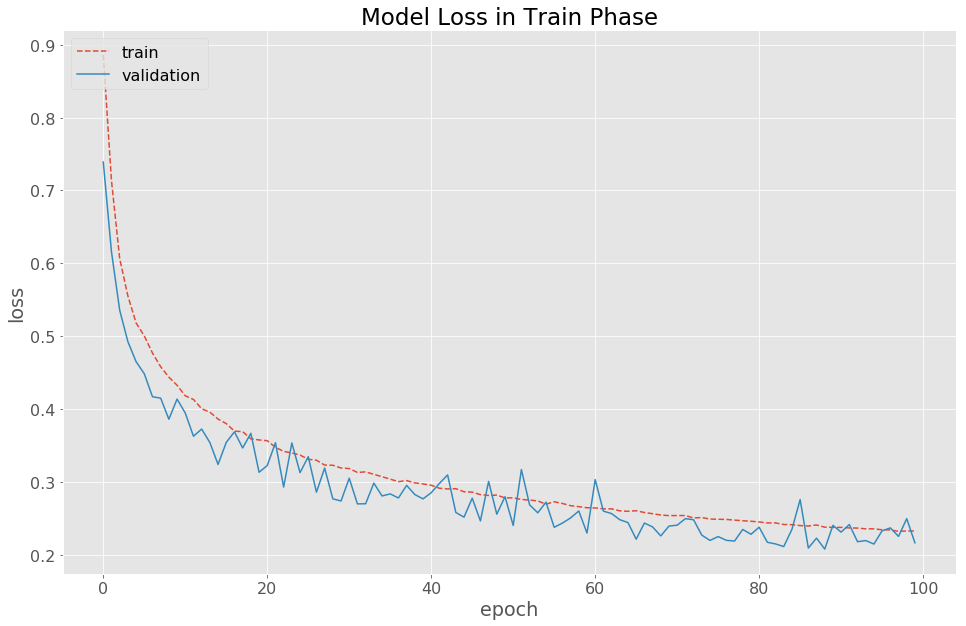

In [12]:
results_junctions = all_places(selected_junctions, NN_TYPE + '_junctions')

In [13]:
results_junctions

,simple_lstm_only_speeds
stat,
corr,0.780679
mae,3.878584
r2,0.606436
rmse,6.506933
